In [1]:
%matplotlib inline 
import torch
import torch.optim as optim
from torchvision import transforms, models
#transforms for image transforms and models for transfer learning(using pretraomed model)
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

In [2]:
# resnet = models.resnet50(pretrained=True)
# modules = list(resnet.children())[:-1] # delete the last fc layer.
# resnet = nn.Sequential(*modules)

resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet34', pretrained=True)

for param in resnet.parameters():
    param.requires_grad_(False)
    #do not update weight

Using cache found in /home/ec2-user/.cache/torch/hub/pytorch_vision_v0.6.0


In [3]:
#use GPU if availabe
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)
#its a summery and fc layers are not listed

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
#we have a content image and a style image...target image will be combination of these two
#max image = 400 h and w to speedup the process
#shape-->control shape of image
def load_image(img_path, max_size=400, shape=None):
    #open image and set color space to RGB
    image = Image.open(img_path).convert('RGB')
    #max(image.size)-->highest dim(w or h)
    if max(image.size) > max_size:
        size = max_size#change the size
    else:
        size = max(image.size)#unchanged
    
    if shape is not None:#for making both content and style having same dims
        size = shape
 
    in_transform = transforms.Compose([
                        transforms.Resize(size), #max will be 400
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), #normalize image
                                             (0.229, 0.224, 0.225))])

    image = in_transform(image).unsqueeze(0)
    
    return image

In [5]:
content = load_image('all_2.jpg').to(device)
style = load_image('1.PNG',shape=content.shape[-2:]).to(device)
#making both content and style having same dims
#third and fourh index of the image will be dims we need-->[-2:]

In [6]:
#convert our images from tensors into numpy images so we can use pyplot to visualize our image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

(-0.5, 399.5, 706.5, -0.5)

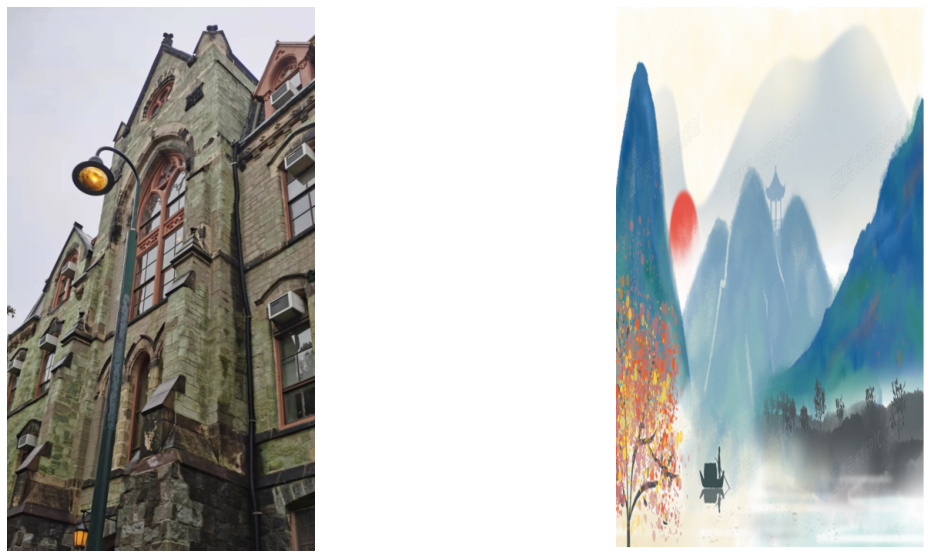

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))#single row and 2 columns
#fixed size of 20*10
ax1.imshow(im_convert(content))
ax1.axis("off")
ax2.imshow(im_convert(style))
ax2.axis("off")

In [8]:
def get_features(image, model):
   #we want the content features of the target image to match features of content image
   #we want the style features of the target image to match features of style image 
    x = image
    x = model.conv1(x)
    x = model.bn1(x)
    x = model.relu(x)
    x = model.maxpool(x)
    i = 0
    features = {}
#     layers = {'7': 'conv2_2',
#               '15': 'conv3_2', 
#               '27': 'conv4_2', 
#               '33': 'conv5_2',}  #content feature extraction
#paper recommand using these layers as features
#we use 5 of these for style extraction
#use 1 of them for content extraction-->conv4-2 because its deep enough to provide high depth features
    for name, layer in model.layer1._modules.items():
        x = layer(x)
        i+=1
        features[f"bneck_{name}_{i}"] = x

    for name, layer in model.layer2._modules.items():
        x = layer(x)
        i+=1
        features[f"bneck_{name}_{i}"] = x

    for name, layer in model.layer3._modules.items():
        x = layer(x)
        i+=1
        features[f"bneck_{name}_{i}"] = x

    for name, layer in model.layer4._modules.items():
        x = layer(x)
        i+=1
        features[f"bneck_{name}_{i}"] = x
    
#     print(features.keys())
            
    return features

In [9]:
content_features = get_features(content, resnet)
style_features = get_features(style, resnet)

In [10]:
#style transfer needs preprocess for better effect
#gram=v^t v
#it help to create texture information related to data
def gram_matrix(tensor):
    _, d, h, w = tensor.size()#batch size(not using this),image depth,height,weight
    tensor = tensor.view(d, h * w)#d is num of feature channels
    gram = torch.mm(tensor, tensor.t())
    return gram

In [11]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
#grams for each layers

In [12]:
#earlier layers are more effective
# style_weights = {'conv2_2': 0.75,
#                  'conv3_2': 0.2,
#                  'conv4_2': 0.2,
#                  'conv5_2': 0.2}

style_weights= {
  'bneck_0_1':19,
  'bneck_1_2':0,
  'bneck_2_3':7,
  'bneck_0_4':0,
  'bneck_1_5':4,
  'bneck_2_6':3,
  'bneck_3_7':2,
  'bneck_0_8':1,
  'bneck_1_9':1,
  'bneck_2_10':1,
  'bneck_3_11':0.5,
  'bneck_4_12':0.1,
  'bneck_5_13':0.5,
  'bneck_0_14':0.01,
  'bneck_1_15':0.005,
  'bneck_2_16':0.001
  }

content_weight = 1  # alpha--->content image weight
style_weight = 1e6  # beta-->style image weight

In [13]:
target = content.clone().requires_grad_(True).to(device)
#we want this target image to adjusted during our optimization process
#at first we initilized it as content image

In [14]:
show_every = 300 #show target image 
optimizer = optim.Adam([target], lr=0.003)
steps = 2100

height, width, channels = im_convert(target).shape
image_array = np.empty(shape=(300, height, width, channels))#to make video at the end of the process
#300 frames
capture_frame = steps/300 #capture frame evey 7 step
counter = 0 #keep tracks of array index

Total loss:  2641205.75
Iteration:  300


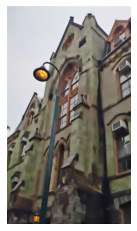

Total loss:  1345181.5
Iteration:  600


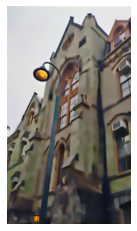

Total loss:  826106.25
Iteration:  900


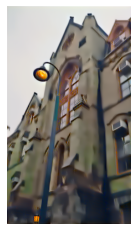

Total loss:  552326.125
Iteration:  1200


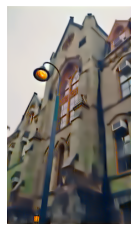

Total loss:  393115.21875
Iteration:  1500


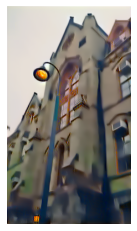

Total loss:  293653.3125
Iteration:  1800


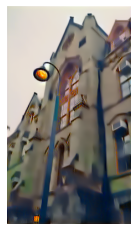

Total loss:  227429.6875
Iteration:  2100


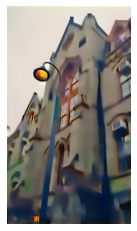

In [15]:
#we have two goals:
  #first goal: for style and target make 2 gram matrices(target and updeted) equal
  #second goal:for content and target make the filtered images similar
for ii in range(1, steps+1):
    target_features = get_features(target, resnet)
    #mse
    #4-2 is content feature extreaction
    #content loss
    content_loss = torch.mean((target_features['bneck_4_12'] - content_features['bneck_4_12'])**2)
    style_loss = 0
    #style loss
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        # *style_weights[layer] use weights we mentioned before
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        _, d, h, w = target_feature.shape
        style_loss += layer_style_loss / (d * h * w)#we need unit loss
  
    total_loss = content_weight * content_loss + style_weight * style_loss
  
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
  
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        print('Iteration: ', ii)
        plt.imshow(im_convert(target))
        plt.axis("off")
        plt.show()
    
    if ii % capture_frame == 0:
        image_array[counter] = im_convert(target)
        counter = counter + 1

(-0.5, 399.5, 706.5, -0.5)

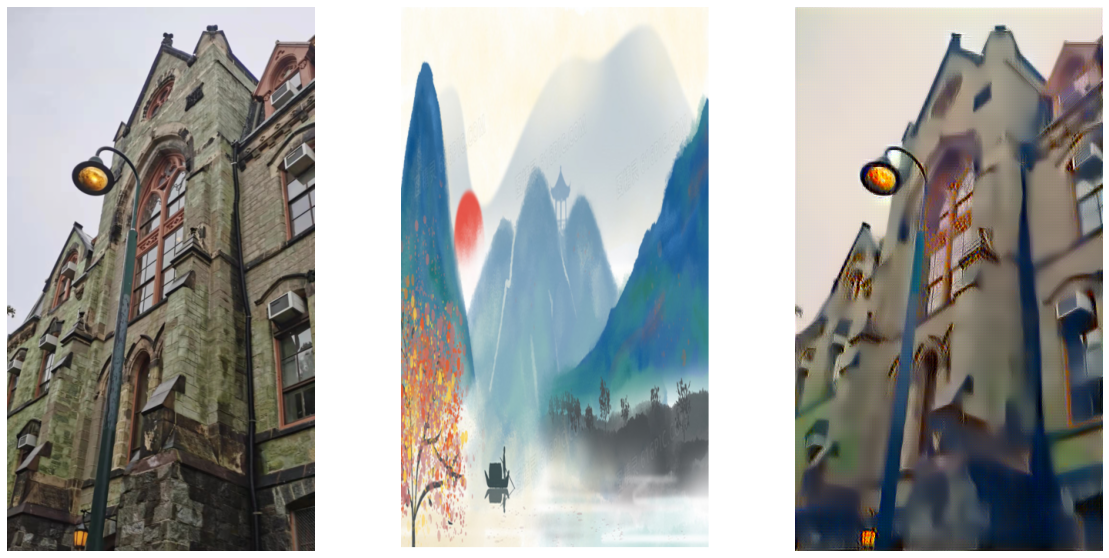

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax1.axis('off')
ax2.imshow(im_convert(style))
ax2.axis('off')
ax3.imshow(im_convert(target))
ax3.axis('off')